In [1]:
from keras.layers import Dense, BatchNormalization, Activation, UpSampling2D, Conv2D, Conv2DTranspose, Reshape, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential, Model, Input
from keras import optimizers, losses, initializers
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
import scipy.io as sio
import sys
import matplotlib.pyplot as plt
import cv2
import keras
%matplotlib inline

Using TensorFlow backend.
/Users/nickstepanov/miniconda3/envs/RoboND/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
class Generator():
    
    def __init__(self):
        g_input = Input(shape=[100])
        H = Dense(32*32*16*16)(g_input)
        H = BatchNormalization()(H)
        H = Reshape( [128,128, 16] )(H)
        H = Conv2D(128, kernel_size=(5,5), strides=2, padding='same')(H)
        H = BatchNormalization()(H)
        H = LeakyReLU()(H)
        H = Conv2DTranspose(128, kernel_size=(2,2), strides=4, padding='same')(H)
        H = LeakyReLU()(H)
        H = Conv2D(128, kernel_size=(5,5), strides=2, padding='same')(H)
        H = BatchNormalization()(H)
        H = LeakyReLU()(H)
        H = Conv2D(128, kernel_size=(5,5), strides=2, padding='same')(H)
        H = BatchNormalization()(H)
        H = LeakyReLU()(H)
        H = Conv2D(3, kernel_size=(5,5), strides=2, padding='same')(H)
        H = BatchNormalization()(H)
        g_V = Activation('sigmoid')(H)
        self.model = Model(g_input,g_V)
        self.model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0007))
    def forward(self, inputs):
        return self.model.predict(inputs)   
generator = Generator()
generator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 262144)            26476544  
_________________________________________________________________
batch_normalization_1 (Batch (None, 262144)            1048576   
_________________________________________________________________
reshape_1 (Reshape)          (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       51328     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
__________

In [3]:
class Discriminator():
    def __init__(self):# Build Discriminative model ...
        d_input = Input(shape=[32,32,3])
        dropout_rate = 0.25
        #H = UpSampling2D((4,4))(d_input)
        H = Conv2D(128, (3, 3), strides=1, padding = 'same')(d_input)
        H = BatchNormalization()(H)
        H = LeakyReLU()(H)
        H = Conv2D(128, (4, 4), strides=(2, 2), padding = 'same')(H)
        H = BatchNormalization()(H)
        H = LeakyReLU()(H)
        H = Conv2D(128, (4, 4), strides=(2, 2), padding = 'same')(H)
        H = BatchNormalization()(H)
        H = LeakyReLU()(H)
        H = Conv2D(128, (4, 4), strides=(2, 2), padding = 'same')(H)
        H = BatchNormalization()(H)
        H = LeakyReLU()(H)
        H = Reshape([128*16])(H)
        H = Dropout(dropout_rate)(H)
        d_V = Dense(1, activation='sigmoid')(H)
        self.model = Model(d_input,d_V)
        self.model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001))
    def forward(self, inputs):
        return self.model.predict(inputs)
discriminator = Discriminator()
discriminator.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_7 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0         
__________

In [4]:
#Plot generated Images
def plot_gen(n_ex=16,dim=(5,5), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[5,100])
    generated_images = generator.forward(noise)

    plt.figure(figsize=figsize)
    #print(generated_images.shape)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = np.zeros([32,32,3])
        #print(img.shape)
        img[:,:,0] = 255*generated_images[i,:,:,0]
        img[:,:,1] = 255*generated_images[i,:,:, 1]
        img[:,:,2] = 255*generated_images[i,:,:, 2]
        #print(img[:,:,0].shape)
        plt.imshow(img.astype(np.uint8))
        plt.axis('off')
    #plt.tight_layout()
    plt.show()

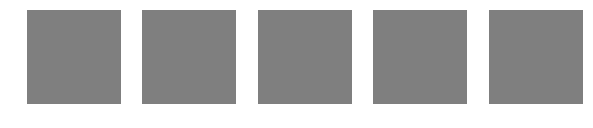

In [5]:
plot_gen()

In [6]:
# Build stacked GAN model
gan_input = Input(shape=[100])
generator.model(gan_input)
H = generator.model(gan_input)
gan_V = discriminator.model(H)
GAN = Model(inputs=gan_input, outputs=gan_V)
#GAN = Sequential()
#GAN.add(generator)
#GAN.add(discriminator)
GAN.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metics = ['binary_crossentropy'])
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         28472719  
_________________________________________________________________
model_2 (Model)              (None, 1)                 794497    
Total params: 29,267,216
Trainable params: 28,741,130
Non-trainable params: 526,086
_________________________________________________________________


In [7]:
from os import listdir
import scipy.misc
def loadImages(path):
    # return array of images

    imagesList = listdir(path)
   
    loadedImages = []
    for image in imagesList:
        if image != '.DS_Store':
            img = cv2.imread(path + image)
            loadedImages.append(img.copy())       
    return loadedImages

path = "/Users/nickstepanov/GAN/EmojiOne/"

# your images in an array
def real_imgs():
    imgs = loadImages(path)
    X_train = []
    Y_train = []
    for img in imgs:
        # you can show every image
        #print(img)
        #pix = scipy.misc.imresize(np.array(img.getdata()).reshape(img.size[0], img.size[1], 3),(32,32))
        X_train.append(img)
        Y_train.append([0.9])
    X_train = np.array(X_train)
    X_train = X_train/255.
    Y_train = np.array(Y_train)
    return X_train, Y_train

In [8]:
#real_imgs()

In [9]:
#Train Discriminator on True dataset
def train_disc(X,Y,epochs=1):
    while epochs>0:
        print ("Epochs on discriminator left: %d "%(epochs))
        discriminator.model.fit(X,Y, batch_size=32,shuffle=True)
        epochs = epochs - 1
def disc_pred(X):
    return discriminator.forward(X)

In [10]:
#Generate Fake dataset
def gen_fake():
    X_fake = []
    Y_fake = []
    numP = 64
    img = generator.forward(np.random.uniform(0,1,size=[numP,100]))
    X_fake = np.array(img)
    X_fake = X_fake/255.

    for i in range(numP):
        Y_fake.append([0.1])
    return np.array(X_fake), np.array(Y_fake)



In [11]:
def accuracy(X,Y):
    y_hat = discriminator.forward(X)
    y_hat_idx = np.argmax(y_hat,axis=1)
    y_idx = np.argmax(Y,axis=0)
    diff = y_idx-y_hat_idx
    n_tot = X_train.shape[0]
    n_rig = (diff==0).sum()
    acc = n_rig*100.0/n_tot
    print ("Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot))



In [12]:
# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.model.layers:
        l.trainable = val
        #print(l.trainable, l)
    net.model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001))
    GAN.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0001))
    #GAN.summary()

Epoch: 0 1000.0%
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 3s 31ms/step - loss: 0.5439
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 1.0235
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3981
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.5180
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 0.5390
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 2s 26ms/step - loss: 0.4957
Epoch 1/3
128/128 [==============================] - 219s 2s/step - loss: 0.3943
Epoch 2/3
128/128 [==============================] - 241s 2s/step - loss: 0.0043
Epoch 3/3
128/128 [==============================] - 212s 2s/step - loss: 0.0049


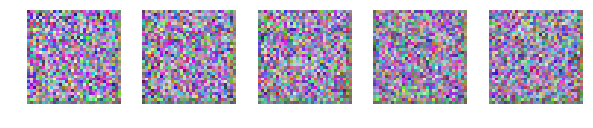

Epoch: 1 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 4s 35ms/step - loss: 0.4998
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 7.7732
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 5.2722
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 2.8217
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 0.7708
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 0.5076
Epoch 1/3
128/128 [==============================] - 214s 2s/step - loss: 0.5614
Epoch 2/3
128/128 [==============================] - 194s 2s/step - loss: 0.0884
Epoch 3/3
128/128 [==============================] - 189s 1s/step - loss: 0.0138


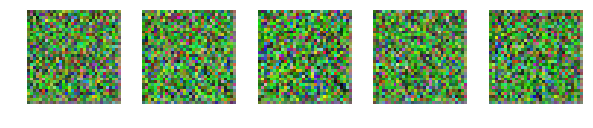

Epoch: 2 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 4s 36ms/step - loss: 0.7888
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 2s 24ms/step - loss: 6.7580
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 4.4571
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 1.8587
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 0.6283
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 0.5348
Epoch 1/3
128/128 [==============================] - 193s 2s/step - loss: 0.2604
Epoch 2/3
128/128 [==============================] - 193s 2s/step - loss: 0.0591
Epoch 3/3
128/128 [==============================] - 190s 1s/step - loss: 0.0107


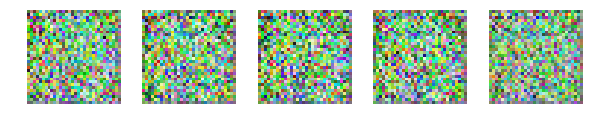

Epoch: 3 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 4s 38ms/step - loss: 0.4807
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 6.9435
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 2s 24ms/step - loss: 3.7880
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 2s 24ms/step - loss: 0.8697
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 2s 24ms/step - loss: 0.4510
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 0.7159
Epoch 1/3
128/128 [==============================] - 187s 1s/step - loss: 1.6940
Epoch 2/3
128/128 [==============================] - 177s 1s/step - loss: 0.0359
Epoch 3/3
128/128 [==============================] - 177s 1s/step - loss: 0.0177


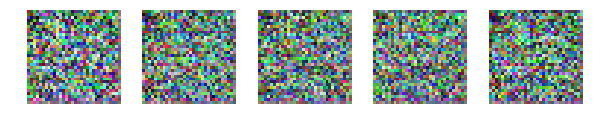

Epoch: 4 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - ETA: 0s - loss: 1.738 - 4s 37ms/step - loss: 1.6331
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 1.9637
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.7721
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3954
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.5388
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.6647
Epoch 1/3
128/128 [==============================] - 181s 1s/step - loss: 0.3097
Epoch 2/3
128/128 [==============================] - 179s 1s/step - loss: 0.0372
Epoch 3/3
128/128 [==============================] - 178s 1s/step - loss:

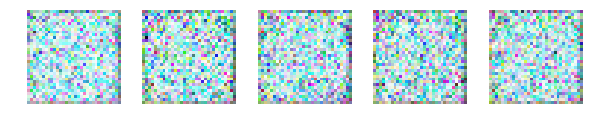

Epoch: 5 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 4s 39ms/step - loss: 0.5451
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4211
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4091
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3866
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3661
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3549
Epoch 1/3
128/128 [==============================] - 184s 1s/step - loss: 0.1027
Epoch 2/3
128/128 [==============================] - 177s 1s/step - loss: 0.0240
Epoch 3/3
128/128 [==============================] - 180s 1s/step - loss: 0.0064


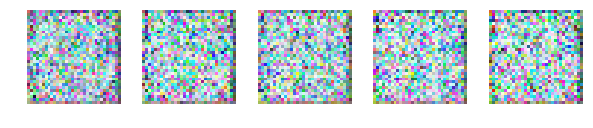

Epoch: 6 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 4s 40ms/step - loss: 0.4848
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 22ms/step - loss: 0.6092
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3905
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4801
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.5084
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4705
Epoch 1/3
128/128 [==============================] - 182s 1s/step - loss: 0.0322
Epoch 2/3
128/128 [==============================] - 179s 1s/step - loss: 0.0091
Epoch 3/3
128/128 [==============================] - 178s 1s/step - loss: 0.0047


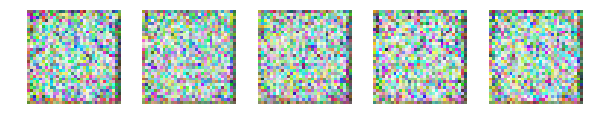

Epoch: 7 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 4s 43ms/step - loss: 0.4009
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.5051
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3897
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4463
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4449
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 22ms/step - loss: 0.3916
Epoch 1/3
128/128 [==============================] - 182s 1s/step - loss: 0.0358
Epoch 2/3
128/128 [==============================] - 179s 1s/step - loss: 0.0082
Epoch 3/3
128/128 [==============================] - 179s 1s/step - loss: 0.0037


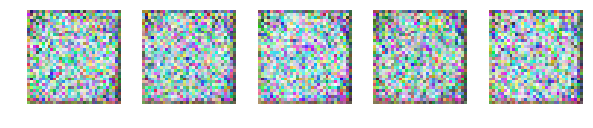

Epoch: 8 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 5s 44ms/step - loss: 0.3859
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4805
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4040
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4621
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4211
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3572
Epoch 1/3
128/128 [==============================] - 185s 1s/step - loss: 0.0241
Epoch 2/3
128/128 [==============================] - 178s 1s/step - loss: 0.0074
Epoch 3/3
128/128 [==============================] - 178s 1s/step - loss: 0.0033


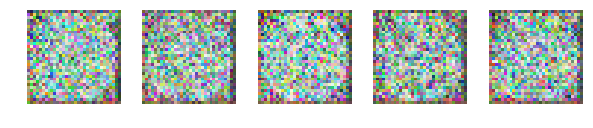

Epoch: 9 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 5s 46ms/step - loss: 0.3613
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.9388
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.3965
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.4863
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.5970
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 21ms/step - loss: 0.6192
Epoch 1/3
128/128 [==============================] - 185s 1s/step - loss: 0.6476
Epoch 2/3
128/128 [==============================] - 178s 1s/step - loss: 0.0942
Epoch 3/3
128/128 [==============================] - 188s 1s/step - loss: 0.0508


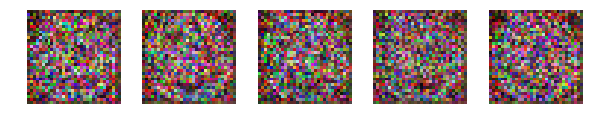

Epoch: 10 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 6s 55ms/step - loss: 0.6401
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 2s 34ms/step - loss: 1.7799
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 2s 27ms/step - loss: 0.6021
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 2s 30ms/step - loss: 0.3824
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 2s 30ms/step - loss: 0.5078
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 2s 27ms/step - loss: 0.6059
Epoch 1/3
128/128 [==============================] - 213s 2s/step - loss: 0.5275
Epoch 2/3
128/128 [==============================] - 180s 1s/step - loss: 0.0660
Epoch 3/3
128/128 [==============================] - 180s 1s/step - loss: 0.0295


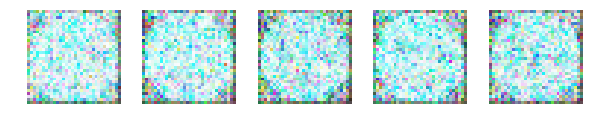

Epoch: 11 
Train on real imgs
Epochs on discriminator left: 1 
Epoch 1/1
104/104 [==============================] - 6s 53ms/step - loss: 0.3883
Generate fake imgs
Train on fake imgs
Epochs on discriminator left: 5 
Epoch 1/1
64/64 [==============================] - 1s 23ms/step - loss: 0.6387
Epochs on discriminator left: 4 
Epoch 1/1
64/64 [==============================] - 1s 22ms/step - loss: 0.4212
Epochs on discriminator left: 3 
Epoch 1/1
64/64 [==============================] - 1s 22ms/step - loss: 0.4441
Epochs on discriminator left: 2 
Epoch 1/1
64/64 [==============================] - 1s 22ms/step - loss: 0.4359
Epochs on discriminator left: 1 
Epoch 1/1
64/64 [==============================] - 1s 22ms/step - loss: 0.3543
Epoch 1/3
128/128 [==============================] - 239s 2s/step - loss: 0.0122
Epoch 2/3
128/128 [==============================] - 233s 2s/step - loss: 0.0042
Epoch 3/3
128/128 [==============================] - 234s 2s/step - loss: 0.0026


In [ ]:
 # train Generator-Discriminator stack on input noise to non-generated output class
def plot_loss(losses):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='discriminitive loss_a')
    plt.plot(losses["r"], label='discriminitive loss_b')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.show()
    
def train_gan(epochs=5):
    X, Y = real_imgs()
    losses = {"d":[], "g":[], "r":[]}
    for i in range(epochs):
        print ("Epoch: %d "%(i))
        make_trainable(discriminator,True)
        print("Train on real imgs")
        train_disc(X,Y)
        print("Generate fake imgs")
        X_f, Y_f = gen_fake()
        #X =np.concatenate((X ,X_f), axis=0)
        #Y =np.concatenate((Y ,Y_f), axis=0)
        print("Train on fake imgs")
        #make_trainable(discriminator,True)
        train_disc(X_f,Y_f,5)
        #y2 = np.ones([1028,1])
        #y2 = discriminator.forward(generator.forward(noise_tr))   
        y2 = np.array([[1]] * 128)
        make_trainable(discriminator,False)
        make_trainable(generator,True)
        #callback = keras.callbacks.ProgbarLogger(count_mode='samples')
        #g_loss = 
        #for j in range(2):
        noise_tr = np.random.uniform(0,1,size=[128,100])
        #GAN.train_on_batch(noise_tr, y2 )#,callbacks = callback)
        GAN.fit(noise_tr, y2, verbose= 1, epochs=3) 
        #print("Progress {:2.1%}".format(j / 200), end="\r")
        #losses["g"].append(g_loss)
        plot_gen()
    plot_loss(losses)
'''
plot_gen()
print("Train on real imgs")
X, Y = real_imgs()
print("Generate fake imgs")
X_f, Y_f = gen_fake()
print("Done")
X =np.concatenate((X ,X_f), axis=0)
Y =np.concatenate((Y ,Y_f), axis=0)
print("Train on fake imgs")
make_trainable(discriminator,True)
train_disc(X,Y, 2)

'''
print("Progress {:2.1%}".format(10), end="\r")
train_gan(100)

In [ ]:
make_trainable(discriminator,True)
print("Train on real imgs")
X, Y = real_imgs()
train_disc(X,Y)